# [Golman and Bhatia (2017)](https://www.sas.upenn.edu/~bhatiasu/Golman%20&%20Bhatia%202017%20CogSci%20PP.pdf), A Cognitive Model of Strategic Deliberation and Decision Making

Abstract:

We study game theoretic decision making using a
bidirectional evidence accumulation model. Our model
represents both preferences for the strategies available to the
decision maker, as well as beliefs regarding the opponent’s
choices. Through sequential sampling and accumulation, the
model is able to intelligently reason through two-player
strategic games, while also generating specific violations of
Nash equilibrium typically observed in these games. The
main ingredients of accumulator models, stochastic sampling
and dynamic accumulation, play a critical role in explaining
these behavioral patterns as well as generating novel
predictions

In [2]:
import numpy as np
from math import e
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
# from joblib import Parallel, delayed
import multiprocessing

%matplotlib inline

The model has a layer of nodes for the player/decision maker's strategies, and a layer for the opponent's strategies. The model iteratively updates each layer's activations based on the other layer's activations. The below steps illustrate how the player's layer is updated based on the opponent's layer.

1. Sample/select a strategy from the opponent's layer, according to the activations and a parameter governing the stochasticity/determinism of the selection process.
2. For each strategy, find the utilties the player would get if the opponent played the strategy selected in (1).
3. Add the utilities from (2) to the player's current activations

A similar process then updates the opponent layer based on the player's layer.

Below is a schematic of the model:

![](bidirectional_accumulation_model.png)

In [3]:
def simulate_decision(strats=None, T=10, payoff_func=None, _lambda=1, 
                      sigmas=None, gamma=None):
    """
    strats: list-like of elements which payoff_func can take.

    T: integer, number of times to update both player and opponent strategy activations
    
    payoff_func: function taking player_strategy, opponent_strategy, for traveler's dilemma,
    must also specify gamma, a reward/penalty parameter.
    
    `_lambda`: float. _lambda is a 'stochasticity parameter'. If it's 0, strategies are sampled 
    from a uniform distribution despite their activations. If `_lambda` is very high, the most 
    active strategy is always chosen.

    `_sigma`: list-like of floats or ints governing the salience (bias) of different strategies.
            or 0.
    """
    if not isinstance(sigmas, np.ndarray):
        sigmas = np.zeros(len(strats))
    
    player_strat_acts   = np.zeros(len(strats))
    opponent_strat_acts = np.zeros(len(strats))
    
    for t in range(T):
        for _ in range(2):
            num = e**(_lambda*(opponent_strat_acts + sigmas))
            dist_over_strats = num / num.sum()
            sampled_strat = np.random.choice(a=strats, p=dist_over_strats)

            player_utilities = [payoff_func(player_strat=x,
                                            opponent_strat=sampled_strat,
                                            gamma=gamma) for x in strats]
            player_strat_acts += player_utilities
            player_strat_acts, opponent_strat_acts = opponent_strat_acts, player_strat_acts
            
    decision = strats[np.argmax(player_strategy_activations)]
    return decision

In [4]:
def parameter_sweep(strats=None, payoff_func=None, Ts=[10,20,30], _lambdas=[.25, .5, 1, 2, 4], 
                    gammas=None, sigmas=[None], sim_count=3000):
    parameter_sweep_results = []
    for T, _lambda, gamma, curr_sigmas in tqdm(product(Ts, _lambdas, gammas, sigmas)):
        for _ in range(sim_count):
            strategy = simulate_decision(strats=strats,
                                         payoff_func=payoff_func, T=T, 
                                         _lambda=_lambda, gamma=gamma,
                                         sigmas=curr_sigmas)
            parameter_sweep_results.append([T, _lambda, gamma, curr_sigmas, strategy])

    parameter_sweep_results = pd.DataFrame(data=parameter_sweep_results, columns=['T', 'lambda', 'gamma', 'sigmas', 'strategy'])
    return parameter_sweep_results

# Traveler's Dilemma

In the traveler's dilemma, two travelers have lost identical items and must request compensation from an airline. The airline, wishing to disincentive outrageously high claims, will accept the lower claim as valid, and pay that amount to both travelers. However, the traveler that submitted the lower claim gets a reward of size `gamma`, while the traveler that submitted the higher claim gets a penalty of equal size.

In [4]:
def travelers_dilemma_payoffs(player_strat, opponent_strat, gamma):
    """
    returns only the player_payoff
    """
    if player_strat > opponent_strat:
        return 0.01*(opponent_strat - gamma)
    elif player_strat == opponent_strat:
        return 0.01*player_strat
    else:
        return 0.01*(player_strat + gamma)

In [5]:
simulate_decision(strats=list(range(20,100,10)), payoff_func=travelers_dilemma_payoffs, gamma=11)

60

This next cell takes about 5 minutes -- there are 30 combinations of the above parameter settings, so the below will need to execute 30 loops, each of which runs `sim_count` (usually 3000) simulations.

In [ ]:
parameter_sweep_results = parameter_sweep(strats=list(range(20,100,10)), payoff_func=travelers_dilemma_payoffs, gammas=[11,19])\
                                         .drop('sigmas', axis=1)

In [7]:
parameter_sweep_results.to_csv('travelers_dilemma_results.csv')

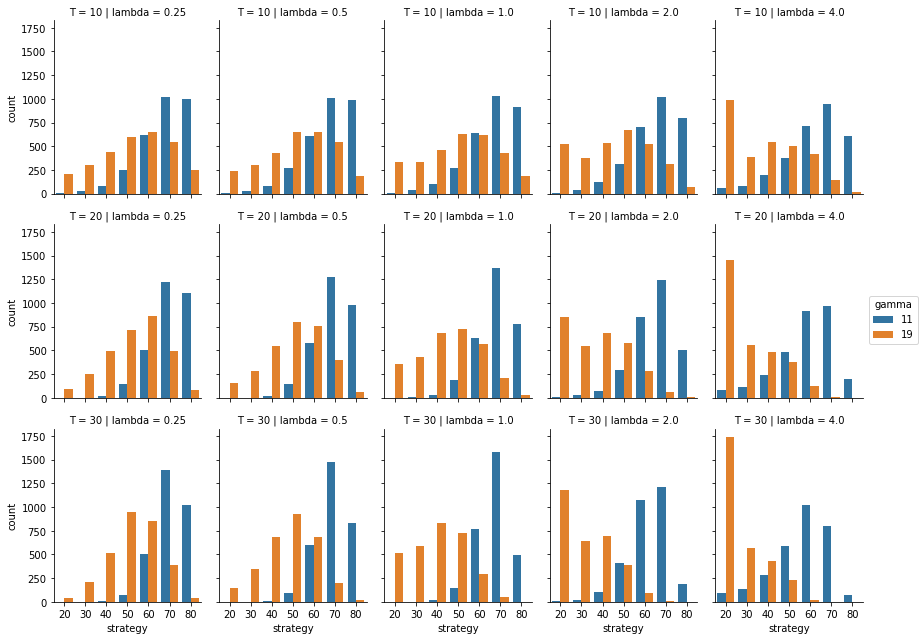

In [8]:
sns.factorplot(x="strategy", col="lambda", row="T", hue="gamma", 
               data=parameter_sweep_results, kind="count", size=3, aspect=.8);

The Nash equilibrium for the Traveler's Dilemma is to submit the lowest possible claim, here 20. In practice people don't do this, typically selecting much higher claims. The above plot shows that, across a wide array of parameter settings, the present model also fails to 'unravel'; that is, the model usually selects a much higher strategy.

# Hi-Lo game

In [9]:
def hi_lo_payoffs(player_strat, opponent_strat, gamma):
    if (player_strat == 'Hi') and (opponent_strat == 'Hi'):
        return 1.0
    elif (player_strat == 'Lo') and (opponent_strat == 'Lo'):
        return gamma
    else:
        return 0

In [55]:
hi_lo_strats = ['Hi', 'Lo']

In [10]:
simulate_decision(strats=['Hi','Lo'],payoff_func=hi_lo_payoffs, T=10, _lambda=.25, gamma=.9)

'Lo'

This next cell takes 15-20 minutes.

In [11]:
gamms = np.linspace(.1,.9,9)
sim_count = 3000

parameter_sweep_results = parameter_sweep(strats=hi_lo_strats, payoff_func=hi_lo_payoffs, gammas=gammas, sim_count=sim_count)
parameter_sweep_results.drop('sigmas', axis=1, inplace=True)

135it [19:55,  8.85s/it]


In [13]:
parameter_sweep_results.to_csv('hi_lo_results.csv')

In [ ]:
strat_counts = parameter_sweep_results.groupby(['T','lambda','gamma','strategy']).size().reset_index()
strat_counts = strat_counts.query("strategy == 'Hi'")
strat_counts.drop('strategy', axis=1, inplace=True)
strat_counts[0] /= sim_count
strat_counts.columns = ['T', 'lambda', 'Payoff for Lo-Lo', 'Probability of Hi']

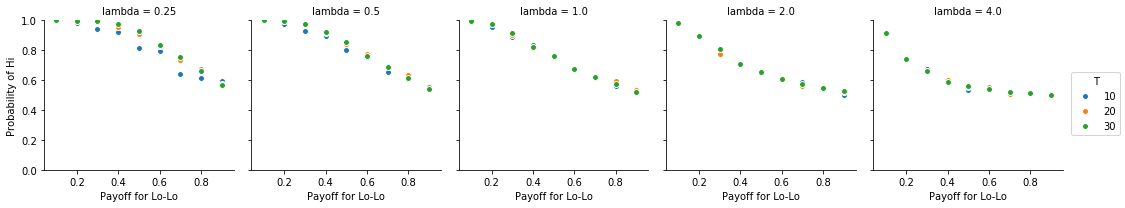

In [54]:
g = sns.FacetGrid(strat_counts, col="lambda",  hue="T")
g = (g.map(plt.scatter, "Payoff for Lo-Lo", "Probability of Hi", edgecolor="w")
      .add_legend()
      .set(ylim=(0,1)))

(There must be a simpler way to generate that plot without all the munging a couple cells above...)

# Boobytrap game

In some games, decision makers do not choose any of the Nash equilibrium strategies when the potential costs of miscoordination are too great. This can be observed in the boobytrap game, which is a standard prisoner’s dilemma
augmented with a third option that allows decision makers to purchase a “boobytrap” to punish their opponent if he or
she defects (Misyak & Chater, 2014). Particularly, we have uij = (0.9,0.9) if both players cooperate, uij = (0.8,0.8) if both players defect, and uij = (0.89,0.89) if both players choose boobytrap. Additionally, uij = (0.7,1) if player 1 cooperates and player 2 defects, uij = (0.9,0.89) if player 1 cooperates and player 2 chooses boobytrap, and uij = (0,0.69) if player 1 defects and player 2 chooses boobytrap (and vice versa, as the game is symmetric). 

In [34]:
# first level of dict is opponent's strategy, second level is player strategy
boobytrap_payoffs_dict = {'boobytrap': {'boobytrap': 0.89, 'coop': 0.9, 'defect': 0.0},
                          'coop':      {'boobytrap': 0.89, 'coop': 0.9, 'defect': 1.0},
                          'defect':    {'boobytrap': 0.69, 'coop': 0.7, 'defect': 0.8}
                          }

def boobytrap_payoffs_func(player_strat, opponent_strat, gamma):
    return boobytrap_payoffs_dict[opponent_strat][player_strat]

In [42]:
boobytrap_strats = ['coop','defect','boobytrap']
simulate_decision(strats=boobytrap_strats, payoff_func=boobytrap_payoffs_func, 
                  T=10, _lambda=1, gamma=None)

'coop'

In [43]:
Ts       = [10, 30]
_lambdas = [.25, 4]

In [58]:
parameter_sweep_results = parameter_sweep(strats=boobytrap_strats, payoff_func=boobytrap_payoffs_func, 
                                          Ts=Ts, _lambdas=_lambdas, gammas=[None])
parameter_sweep_results.drop('sigmas', axis=1, inplace=True)

4it [00:34,  8.75s/it]


In [59]:
parameter_sweep_results.to_csv('boobytrap_results.csv')

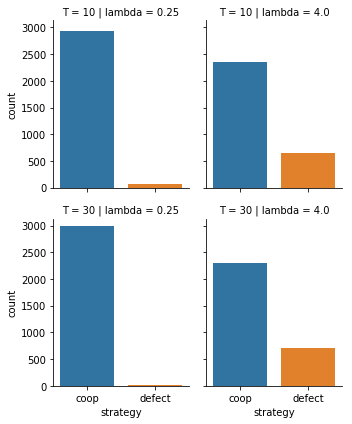

In [64]:
sns.factorplot(x="strategy", col="lambda", row="T", data=parameter_sweep_results, kind="count", size=3, aspect=.8);

Model never decides to set boobytrap, and almost always decides to cooperate, like people do, but contrary to nash equilibrium theory.

# Heads-or-tails coordination game

In [6]:
def heads_or_tails_payoffs(player_strat, opponent_strat, gamma):
    return 1 if player_strat == opponent_strat else 0

Now we try modeling the effect of a particularly salient strategy, e.g., head of a coin, by setting the sigma for one of the strategies above 0.

In [7]:
heads_tails_strats = ['heads', 'tails']
simulate_decision(strats=heads_tails_strats, payoff_func=heads_or_tails_payoffs, 
                  T=10, _lambda=1, sigmas=[.5,0], gamma=None)

'heads'

In [8]:
Ts       = [10, 20, 30]
_lambdas = [.25, .5, 1, 2, 4]
sigmas   = [np.array((x,y)) for (x,y) in product(np.linspace(.1,1.0,10), [0])]
gammas   = ['None']

The below takesa about 20 minutes.

In [12]:
parameter_sweep_results = parameter_sweep(strats=heads_tails_strats, payoff_func=heads_or_tails_payoffs, Ts=Ts,
                                         _lambdas=_lambdas, sigmas=sigmas, gammas=gammas)

150it [21:24,  8.56s/it]


In [14]:
parameter_sweep_results.head()

,T,lambda,gamma,sigmas,strategy
0,10,0.25,None,"[0.1, 0.0]",heads
1,10,0.25,None,"[0.1, 0.0]",heads
2,10,0.25,None,"[0.1, 0.0]",heads
3,10,0.25,None,"[0.1, 0.0]",tails
4,10,0.25,None,"[0.1, 0.0]",tails


In [16]:
parameter_sweep_results.to_pickle('heads_tails_results.pkl')

In [17]:
parameter_sweep_results['sigmas'] = parameter_sweep_results['sigmas'].apply(lambda x: x[0])

In [34]:
# parameter_sweep_results['gamma'] = 'None'

In [20]:
sim_count = 3000

In [41]:
strat_counts = parameter_sweep_results.groupby(['T','lambda','gamma','sigmas','strategy']).size().reset_index()
strat_counts = strat_counts.query("strategy == 'heads'")
strat_counts.drop(['strategy','gamma'], axis=1, inplace=True)
strat_counts[0] /= sim_count
strat_counts.columns = ['T', 'lambda', 'Salience of heads', 'Probability of heads']
strat_counts.head()

,T,lambda,Salience of heads,Probability of heads
0,10,0.25,0.1,0.594000
2,10,0.25,0.2,0.586000
4,10,0.25,0.3,0.610000
6,10,0.25,0.4,0.631333
8,10,0.25,0.5,0.629000


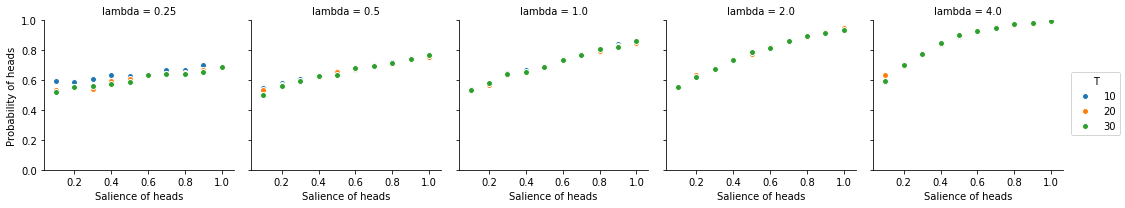

In [43]:
g = sns.FacetGrid(strat_counts, col="lambda",  hue="T")
g = (g.map(plt.scatter, "Salience of heads", "Probability of heads", edgecolor="w")
      .add_legend()
      .set(ylim=(0,1)))

# Facility location game

In [258]:
def simulate_decision_asymm(player_strats=None, opponent_strats=None, 
                            player_payoff=None, opponent_payoff=None, T=10, _lambda=1, sigmas=None, gamma=None):
    if not isinstance(sigmas, np.ndarray):
        sigmas = np.zeros(len(player_strats))
    
    player_strat_acts   = np.zeros(len(player_strats))
    opponent_strat_acts = np.zeros(len(opponent_strats))
    
    for t in range(T):
        for _ in range(2):
            
            scaled_acts = e**(_lambda*(opponent_strat_acts + sigmas))
            dist_over_oppo_strats = scaled_acts / scaled_acts.sum()
            oppo_sampled_strat = np.random.choice(a=opponent_strats, p=dist_over_oppo_strats)

            player_utilities = [player_payoff[oppo_sampled_strat][player_strat] for player_strat in player_strats]
            player_strat_acts += player_utilities
            
            player_strats, opponent_strats = opponent_strats, player_strats
            player_payoff, opponent_payoff = opponent_payoff, player_payoff
            player_strat_acts, opponent_strat_acts = opponent_strat_acts, player_strat_acts
            
    decision = player_strats[np.argmax(player_strat_acts)]
    return decision

In [259]:
oppo_facility_location_payoffs_dict = {'A': {'B': 5, 'D': 4, 'F': 3},
                                       'C': {'B': 2, 'D': 3, 'F': 2},
                                       'E': {'B': 3, 'D': 4, 'F': 1}
                                       }

play_facility_location_payoffs_dict = {'B': {'A':1, 'C':4, 'E':3},
                                       'D': {'A':2, 'C':3, 'E':2},
                                       'F': {'A':3, 'C':4, 'E':5}
                                      }

In [268]:
player_strats    = ('A', 'C', 'E')
opponent_strats  = ('B', 'D', 'F')

simulate_decision_asymm(player_strats=player_strats, 
                        opponent_strats=opponent_strats, 
                        player_payoff=play_facility_location_payoffs_dict, 
                        opponent_payoff=oppo_facility_location_payoffs_dict,
                        T=10, _lambda=1, sigmas=[None], gamma=None)

'C'

In [252]:
Ts       = [1,3,6]
_lambdas = [.1, .2, .5, .8, 1.5]
sim_count = 3000

parameter_sweep_results = []
for T, _lambda in tqdm(product(Ts, _lambdas)):
    for _ in range(sim_count):
        strategy = simulate_decision_asymm(player_strats=player_strats,opponent_strats=opponent_strats, 
                                           player_payoff=play_facility_location_payoffs_dict, 
                                           opponent_payoff=oppo_facility_location_payoffs_dict,
                                           T=T, _lambda=_lambda)
        
        parameter_sweep_results.append([T, _lambda, strategy])

parameter_sweep_results = pd.DataFrame(data=parameter_sweep_results, 
                                       columns=['T', 'lambda', 'strategy'])

15it [00:21,  1.45s/it]


In [253]:
parameter_sweep_results.to_csv('facility_location_game.csv')

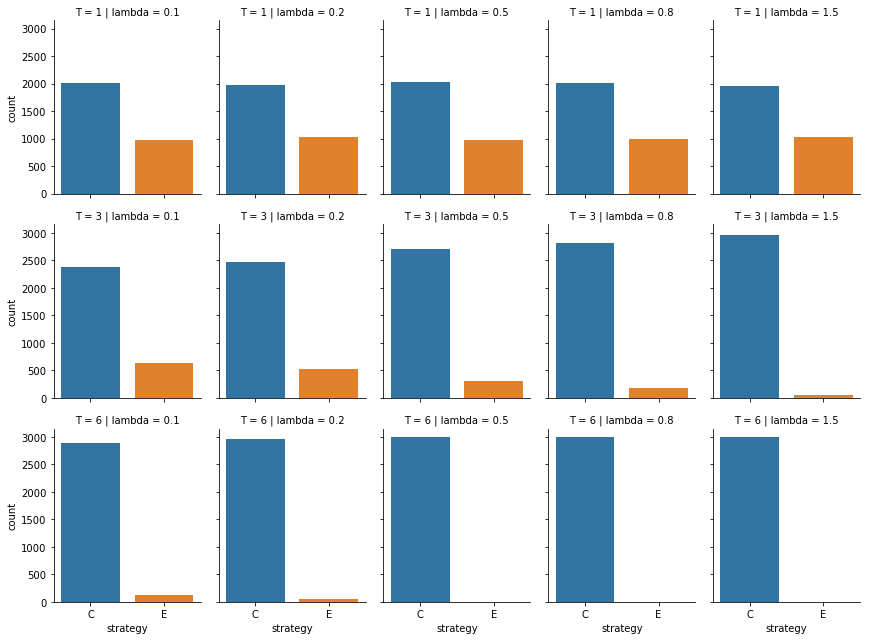

In [254]:
sns.factorplot(x="strategy", col="lambda", row="T", 
               data=parameter_sweep_results, kind="count", size=3, aspect=.8);

# Post-script

Somehow, testing showed that parallelizing the code didn't quicken things, even when running 300 simulations per settting (i.e., per job)....? This might be something to revisit later.

In [3]:
# num_cores = multiprocessing.cpu_count()
# print(num_cores)

16


In [4]:
# def repeat_simulations(strats, payoff_func, T, _lambda, gamma, curr_sigmas, sim_count):
#     sim_results = []
#     for _ in range(sim_count):
#         strategy = simulate_decision(strats=strats, payoff_func=payoff_func,
#                                      T=T, _lambda=_lambda, gamma=gamma,
#                                      sigmas=curr_sigmas)
#         sim_results.append([T, _lambda, gamma, curr_sigmas, strategy])
#     return sim_results

In [15]:
# def parameter_sweep1(strats=None, payoff_func=None, Ts=[10,20,30], _lambdas=[.25, .5, 1, 2, 4], 
#                     gammas=None, sigmas=[None], sim_count=30):
#     results = Parallel(n_jobs=num_cores)(delayed(repeat_simulations)(strats, payoff_func, T, _lambda, gamma, curr_sigmas, sim_count)\
#                                                                      for T, _lambda, gamma, curr_sigmas in product(Ts, _lambdas, 
#                                                                                                                    gammas, sigmas))
#     print("Finished simulations. Now reshaping results into a dataframe.")
#     results = [result for sublist in results for result in sublist]
#     parameter_sweep_results = pd.DataFrame(data=results, columns=['T', 'lambda', 'gamma', 'sigmas', 'strategy'])
#     return parameter_sweep_results